# Visual Odometry

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from lib import hest, PI, homogeneous, triangulate

In [2]:
# camera matrix
K = np.loadtxt('data/week11-12/K.txt')

# images
im = []
for i in range(20):
    image = cv2.imread("data/week11-12/sequence/0000{:02d}.png".format(i+1))[:, :, ::-1]
    im.append(image)

### 1. SIFT matches

In [3]:
im0, im1, im2 = im[0], im[1], im[2]
n_im = len(im)

In [4]:
sift = cv2.SIFT_create(nfeatures=2000)
kps, des = [], []
for i in range(n_im):
    kp_i, d = sift.detectAndCompute(im[i], None)
    kps.append(np.array([k.pt for k in kp_i]))
    des.append(d)

bf = cv2.BFMatcher(crossCheck=True)
matches = []
for i in range(n_im - 1):
    matches_i = bf.match(des[i], des[i + 1])
    matches_i = np.array([(m.queryIdx, m.trainIdx) for m in matches_i])
    matches.append(matches_i)

### 2. Essential matrix with RANSAC and relative pose

We can estimate $\textbf{F}$ or $\textbf{E}$ with RANSAC.

\begin{align*}
	\textbf{E} &= \textbf{R}[\textbf{t}]_\times\\
	0 = \textbf{E}(s\textbf{t}) &= \textbf{R}[\textbf{t}]_\times (s\textbf{t})
\end{align*}

$\textbf{E}$ has 3 degrees of freedom: 3 from the rotation, 2 from the scale invariant translation. Each pair of points fixes 1 degrees of freedom so we need 5 pairs of points.

In [5]:
Es = []
Rs = []
ts = []
for i in range(2):
    points_i   = kps[i    ][matches[i][:, 0]]
    points_ip1 = kps[i + 1][matches[i][:, 1]]

    E_i, mask = cv2.findEssentialMat(
        points_i,
        points_ip1,
        cameraMatrix=K,
        method=cv2.RANSAC
    )
    Es.append(E_i)
    _, R, t, _ = cv2.recoverPose(Es[i], points_i, points_ip1, K)
    inlier = np.argwhere(mask.flatten())
    Rs.append(R)
    ts.append(t)
    matches[i] = matches[i][inlier.flatten()].reshape((-1, 2))

R1 = Rs[0]
t1 = ts[0]

In [6]:
E01, mask = cv2.findEssentialMat(
    points_i,
    points_ip1,
    cameraMatrix=K,
    method=cv2.RANSAC
)
_, R1, t1, _ = cv2.recoverPose(E01, points_i, points_ip1, K)

### 3. Subset of features in 3 consecutive images

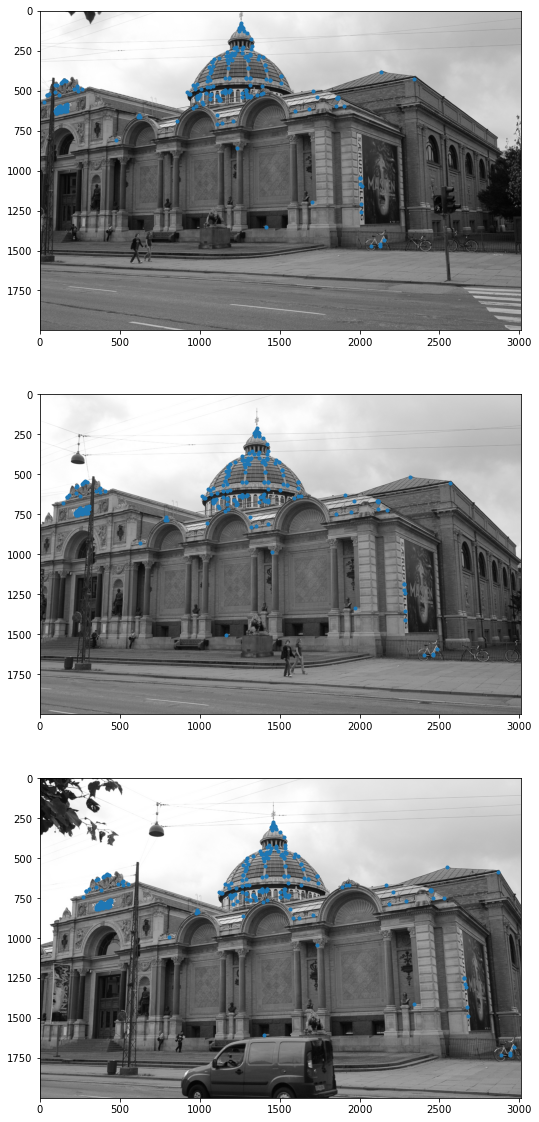

In [7]:
_, idx01, idx12 = np.intersect1d(matches[0][:,1], matches[1][:,0], return_indices=True)

points = []
points.append(kps[0][matches[0][idx01, 0]])
points.append(kps[1][matches[1][idx12, 0]])
points.append(kps[2][matches[1][idx12, 1]])

fig, ax = plt.subplots(3, figsize=(45, 20))
for i in range(3):
    ax[i].imshow(im[i])
    ax[i].plot(points[i][:, 0], points[i][:, 1], '.')

### 4. Triangulation and pose estimation

We know that we can find the pose of two cameras relative to each other. Given a third image and camera:

   - fix the scale with the first 2 camera
   - get the 3D points
   - Use them to get the pose of the 3rd camera (perspective n points)
   
#### Perspective-$n$-point problem:
Estimate the pose of a calibrated camera from $n$ corresponding 3D-2D correspondences.

Naïvely, we could estimate the projection matrix of the camera and get:
$\begin{bmatrix}\textbf{R} & \textbf{t} \end{bmatrix} = \textbf{K}^{-1}
\tilde{\textbf{P}}$, but is has more degrees of freedom and requires more points.

This uses more point and it's less precise (more degrees of freedom). We have 6 degrees of freedom (3 rotation, 3 translation as scale matters (fixed)). Each pair of point fixes 2 degrees, we need 3 points.

The three 2D points give 3 pairwise angle, the three 3D points give 3 pairwise distances. This give 4 possible solutions and we need a 4th point to decide which to take.

Once we get the pose of the camera, we can get its position:
\begin{align*}
	\textbf{T}_{world-cam} =  \begin{bmatrix}
		\textbf{R} & \textbf{t}\\
		\textbf{0} & 1
	\end{bmatrix}\\
	\textbf{T}_{cam-world} = \begin{bmatrix}
		\textbf{R}^T & -\textbf{R}^T\textbf{t}\\
		\textbf{0} & 1
	\end{bmatrix}
\end{align*}

In [8]:
# Assume that camera 0 is at position 0
# Use the decomposition of essential matrix 01 to find the pose of
# camera 2
# You know K so you can get the projection matrix
# You can now use triangulate

In [9]:
R0 = np.eye(3)
t0 = np.array([[0, 0, 0]]).T
T0 = np.vstack((np.hstack([R0, t0])))
T1 = np.vstack((np.hstack([R1, t1])))
P0 = K @ T0
P1 = K @ T1
Qs = []
for i in range(len(points[0])):
    Qs.append(triangulate(np.array([points[0][i], points[1][i]]), [P0, P1]))

In [10]:
Qs = np.array(Qs).reshape(-1, 3)

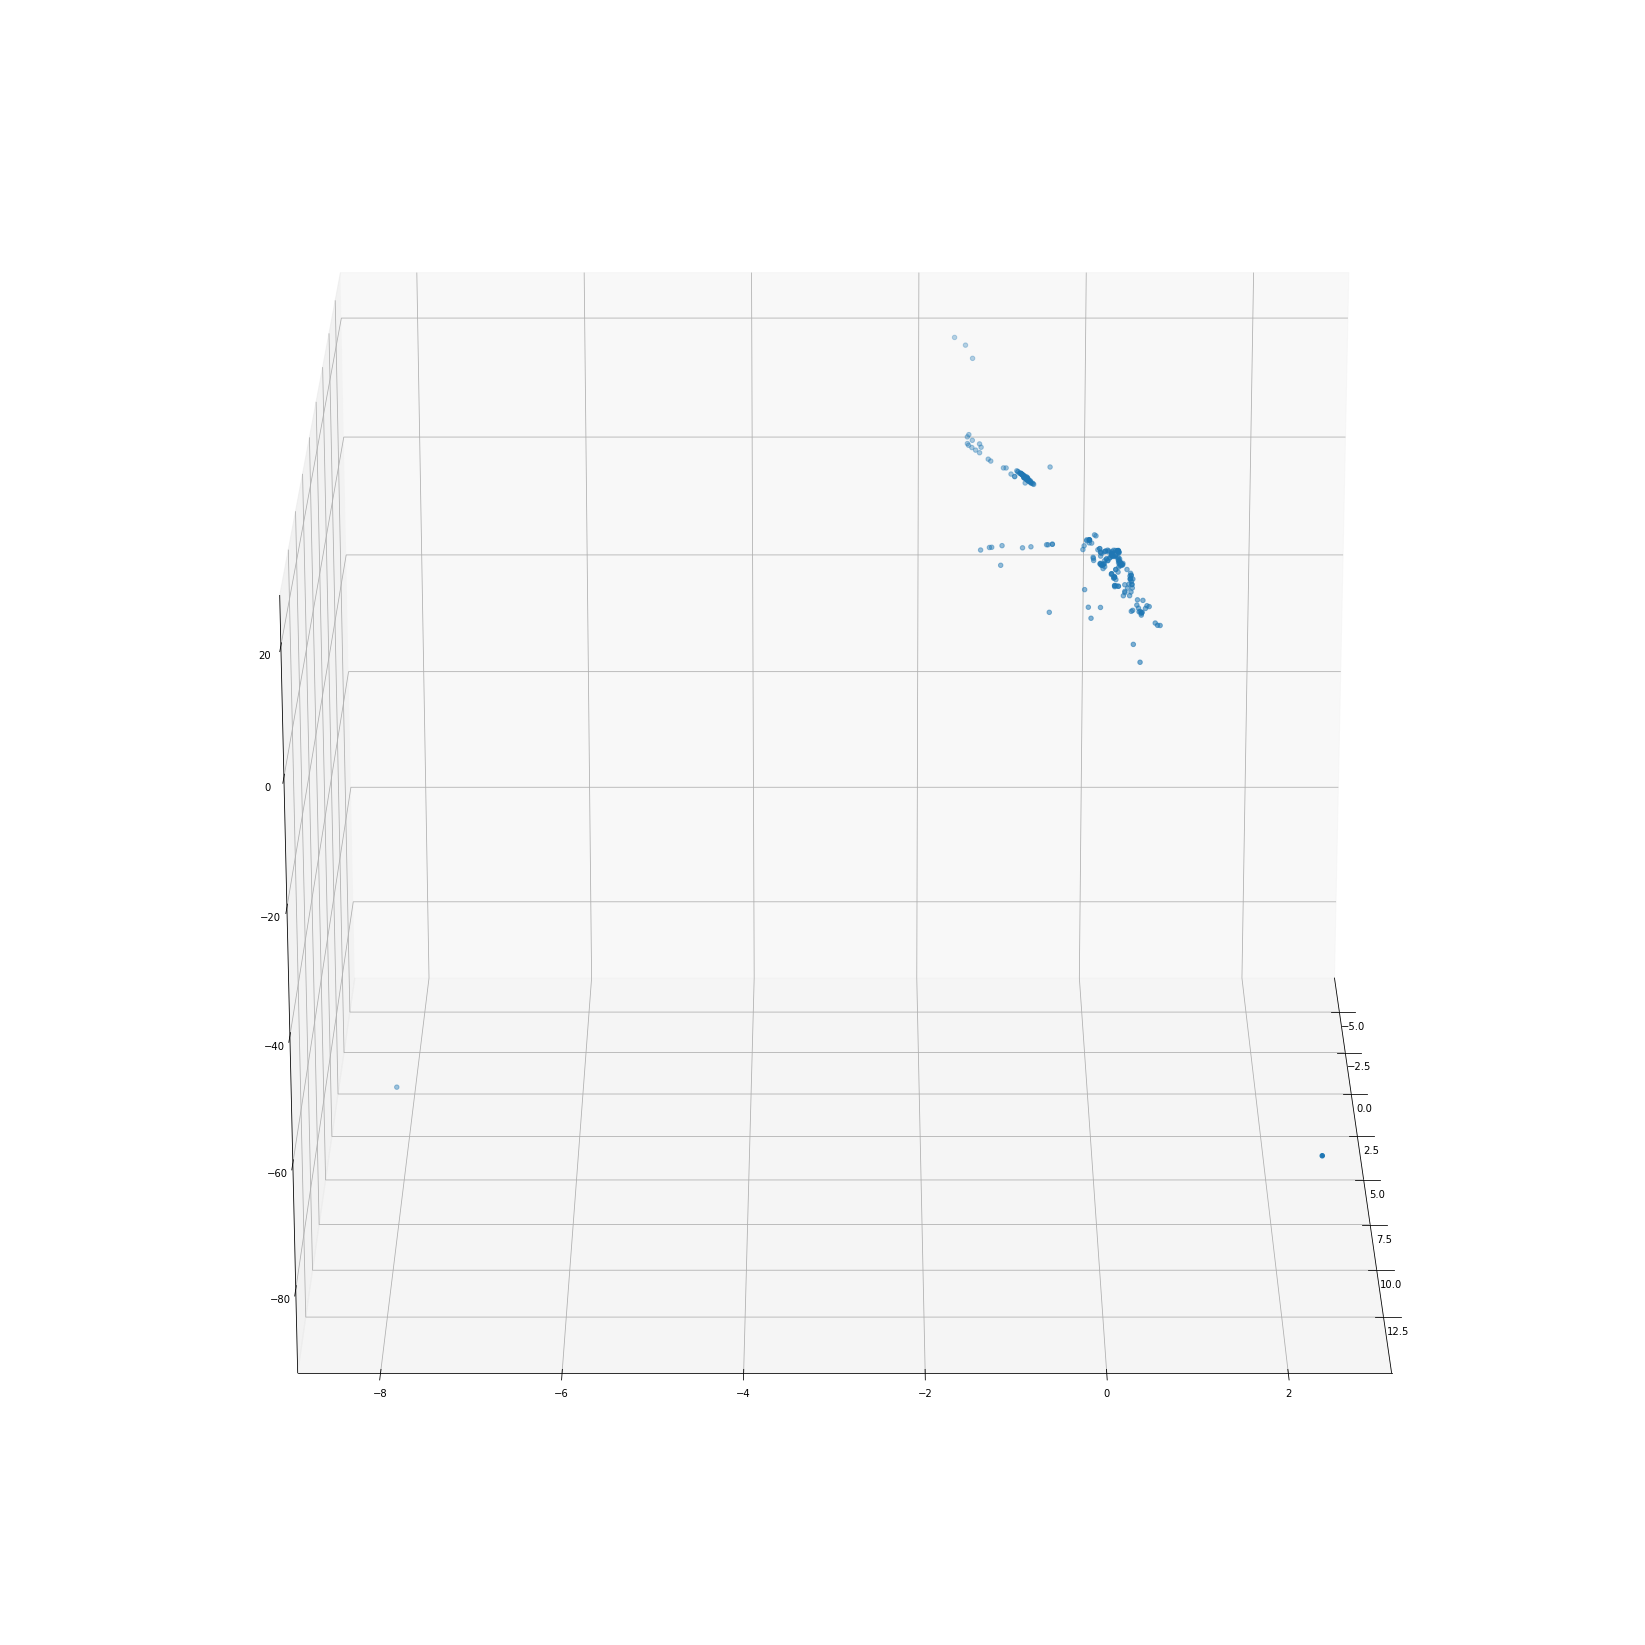

In [11]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(projection="3d")
Qs = Qs[Qs[:, 2] > -100]
ax.scatter(Qs[:, 0], Qs[:, 1], Qs[:, 2], '.');
ax.view_init(20, 0)

### 5. All images

In [12]:
def filter_points(Q):
    Q = Q[np.abs(Q[:, 0]) < 100]
    Q = Q[np.abs(Q[:, 1]) < 100]
    Q = Q[np.abs(Q[:, 2]) < 100]
    return Q

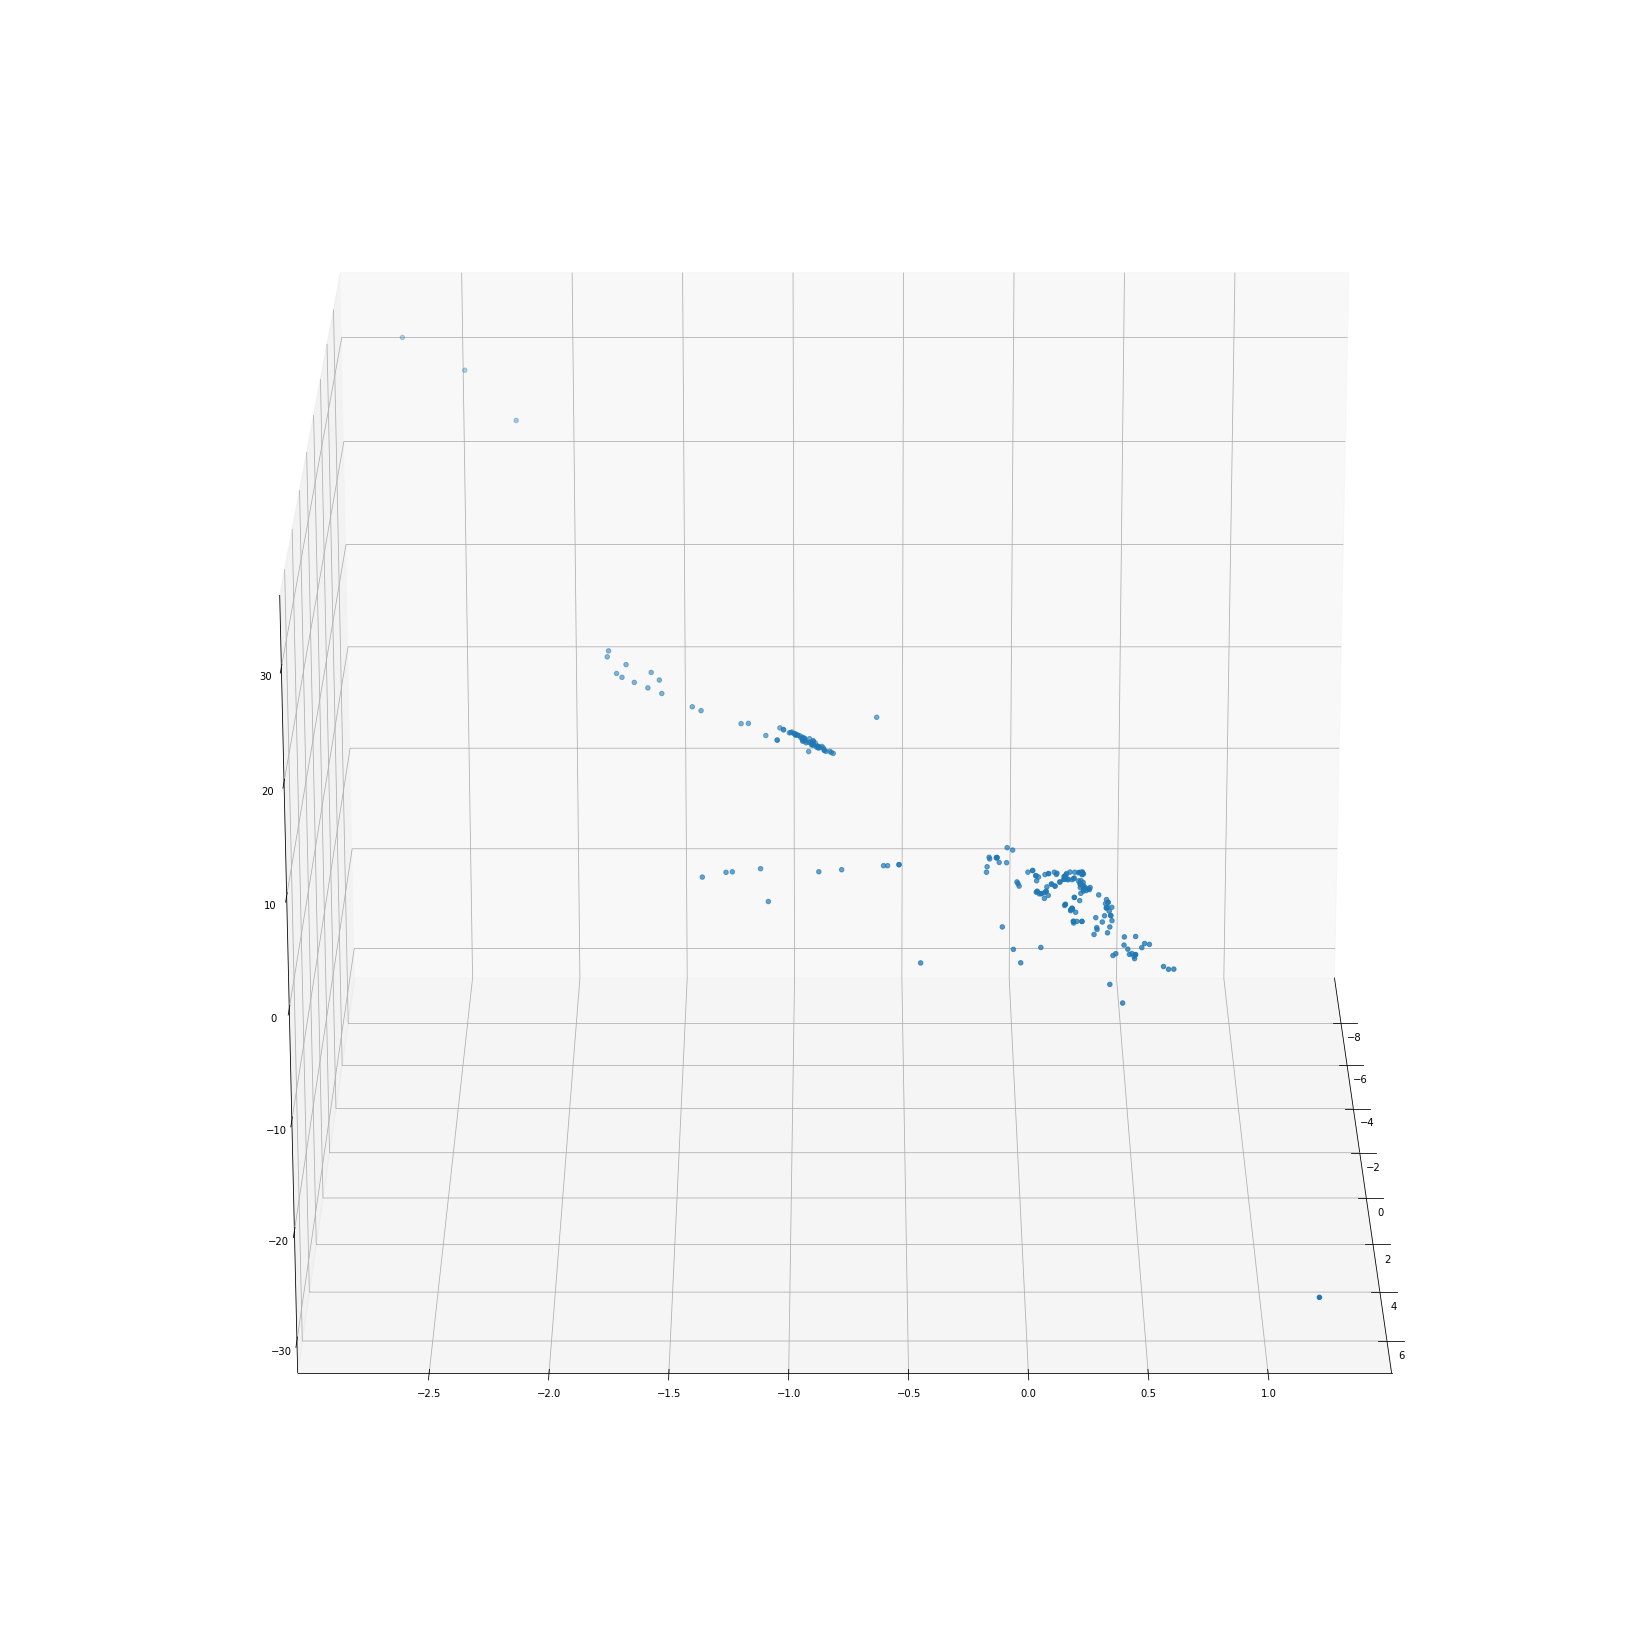

In [13]:
Rs = [R0]
ts = [t0]

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(projection="3d")

for i in range(1):#len(matches) - 1):# Point in common in 3 images
    _, idx01, idx12 = np.intersect1d(
        matches[i    ][:,1],
        matches[i + 1][:,0],
        return_indices=True
    )
    points = []
    points.append(kps[i    ][matches[i    ][idx01, 0]])
    points.append(kps[i + 1][matches[i + 1][idx12, 0]])
    points.append(kps[i + 2][matches[i + 1][idx12, 1]])

    E_i, mask = cv2.findEssentialMat(
        points[0],
        points[1],
        cameraMatrix=K,
        method=cv2.RANSAC
    )
    points_i   = kps[i    ][matches[i][:, 0]]
    points_ip1 = kps[i + 1][matches[i][:, 1]]
    _, R, t, _ = cv2.recoverPose(E_i, points_i, points_ip1, K)
    inlier = np.argwhere(mask.flatten())
    Rs.append(R)
    ts.append(t)
    matches[i] = matches[i][inlier.flatten()].reshape((-1, 2))

    # Triangulation
    T0 = np.vstack((np.hstack([Rs[i], ts[i]])))
    T1 = np.vstack((np.hstack([Rs[i + 1], ts[i + 1]])))
    P0 = K @ T0
    P1 = K @ T1
    Qs = []
    for i in range(len(points[0])):
        Qs.append(triangulate(np.array([points[0][i], points[1][i]]), [P0, P1]))
    Qs = filter_points(np.array(Qs).reshape(-1, 3))
    ax.scatter(Qs[:, 0], Qs[:, 1], Qs[:, 2], '.');
    ax.view_init(20, 0)